<a href="https://colab.research.google.com/github/janlight/Covid-19_X-ray_DL_project/blob/main/covid_project(resnet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# **Covid-19 X-ray Model**

In [ ]:
!unzip -qq '/content/drive/MyDrive/archive.zip'

# **Covid XRay Dataset**
- This is the dataset that i gathered from different sources for Covid 19 Detection.There are around 3000 images in those two files and there is a handling code in the Notebook named "Official" at the end.
- Without Covid(0), With Covid(1)로 라벨링 되어있다.

## **ResNet50 모델 구현**

In [1]:
import os
import random
import numpy as np
import math
import itertools

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers.experimental import preprocessing
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report


import re
import imageio
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

    
print("Tensorflow version ", tf.__version__)

Tensorflow version  2.8.0


In [2]:
np.random.seed(7)
random.seed(7)

tf.random.set_seed(7)

## **혼합 정밀도**
- 혼합 정밀도를 사용하여 메모리 사용을 최적화하며 빠른 속도로 처리한다.
- 아래 사용은 GPU용 데이터 타입 정책이고, 만일 TPU를 사용한다면, mixed_bfloat16 를 사용한다.
- 현재 코랩의 환경에서는 nvidia gpu 환경이 아니기 때문에 사용하지 않는다.

In [4]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  Tesla P100-PCIE-16GB, compute capability 6.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale


In [3]:
# Cosine annealing scheduler
from tensorflow.keras.callbacks import Callback
class CosineAnnealingScheduler(Callback):

    def __init__(self, T_max, eta_max, eta_min=0, verbose=0):
        super(CosineAnnealingScheduler, self).__init__()
        self.T_max = T_max
        self.eta_max = eta_max
        self.eta_min = eta_min
        self.verbose = verbose

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = self.eta_min + (self.eta_max - self.eta_min) * (1 + math.cos(math.pi * epoch / self.T_max)) / 2
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nEpoch %05d: CosineAnnealingScheduler setting learning '
                  'rate to %s.' % (epoch + 1, lr))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
tf.config.optimizer.set_jit(True)

BATCH_SIZE = 128

CLASSES = ['non-COVID', 'COVID-19']
NUM_CLASSES = len(CLASSES)
IMAGE_SIZE = [224, 224]
input_shape = (224, 224, 3)
LOSS = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

METRICS = ['accuracy']

Epochs = 50
Early_Stop = 15

OPTIMIZER = tensorflow.keras.optimizers.Adam(lr = 1e-2, decay = 1e-5)

Fine_Tune_Epochs = 60
Fine_Tune_Early_Stop = 20
Fine_Tune_OPTIMIZER = tensorflow.keras.optimizers.Adam(lr = 1e-3, decay = 1e-6)
Fine_Tune_filepath = "/content/drive/MyDrive/Best-Model-FT_resnet.h5"

Callbacks = [
    CosineAnnealingScheduler(Epochs, 1e-3, 1e-6),
    EarlyStopping(monitor='val_accuracy', patience=Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)]

FT_Callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=2, mode='min', min_delta=0.0001, cooldown=1, min_lr=1e-6),
    ModelCheckpoint(Fine_Tune_filepath, monitor='val_accuracy', verbose=2, save_best_only=True, save_weights_only=False, mode='max'),
    EarlyStopping(monitor='val_loss', patience=Fine_Tune_Early_Stop, mode='auto', min_delta=0.00001, verbose=2, restore_best_weights=True)]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
filenames = tf.io.gfile.glob('/content/drive/MyDrive/archive/DATA/DATA/non-COVID/*')
filenames.extend(tf.io.gfile.glob('/content/drive/MyDrive/archive/DATA/DATA/COVID-19/*'))
random.shuffle(filenames)

In [6]:
filenames[:10]

['/content/drive/MyDrive/archive/DATA/DATA/non-COVID/IM-0280-0001.jpeg',
 '/content/drive/MyDrive/archive/DATA/DATA/COVID-19/person755_bacteria_2659.jpeg',
 '/content/drive/MyDrive/archive/DATA/DATA/COVID-19/person81_virus_152.jpeg',
 '/content/drive/MyDrive/archive/DATA/DATA/COVID-19/person1689_bacteria_4472.jpeg',
 '/content/drive/MyDrive/archive/DATA/DATA/COVID-19/person1411_bacteria_3603.jpeg',
 '/content/drive/MyDrive/archive/DATA/DATA/COVID-19/person1217_virus_2063.jpeg',
 '/content/drive/MyDrive/archive/DATA/DATA/COVID-19/person1506_virus_2616.jpeg',
 '/content/drive/MyDrive/archive/DATA/DATA/non-COVID/NORMAL2-IM-1039-0001.jpeg',
 '/content/drive/MyDrive/archive/DATA/DATA/COVID-19/person1414_bacteria_3627.jpeg',
 '/content/drive/MyDrive/archive/DATA/DATA/non-COVID/IM-0293-0001.jpeg']

In [7]:
COUNT_Non_COVID = len([filename for filename in filenames if "/non-COVID/" in filename])
print("Non-COVID images count : " + str(COUNT_Non_COVID))

COUNT_COVID = len([filename for filename in filenames if "/COVID-19/" in filename])
print("COVID-19 images count : " + str(COUNT_COVID))

Non-COVID images count : 1301
COVID-19 images count : 1790


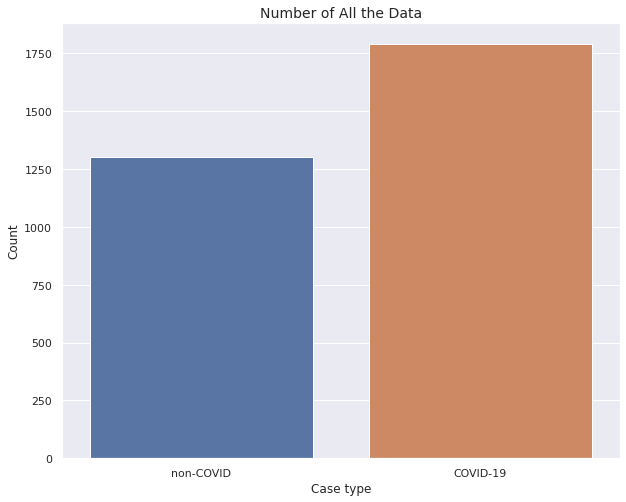

       Cases  Cases_count
0  non-COVID         1301
1   COVID-19         1790


In [8]:
data = {'Cases':['non-COVID', 'COVID-19'],
        'Cases_count':[COUNT_Non_COVID, COUNT_COVID]
       }

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(10,8))
sns.barplot(x=df.index, y= df['Cases_count'].values)
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(df.index)), ['non-COVID', 'COVID-19'])
plt.show()

print(df)

In [9]:
train_filenames, test_filenames = train_test_split(filenames, test_size=0.2)
train_filenames, val_filenames = train_test_split(train_filenames, test_size=0.2)

In [10]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
test_list_ds = tf.data.Dataset.from_tensor_slices(test_filenames)

In [11]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Test_IMG_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
print("Testing images count: " + str(Test_IMG_COUNT))

Training images count: 1977
Validating images count: 495
Testing images count: 619


In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return int(parts[-2] == CLASSES)

In [13]:
def decode_img(img):
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, IMAGE_SIZE)

In [14]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [15]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [16]:
def prepare_for_training(ds, cache=True):
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)

    if cache:
        ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [17]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)
test_ds = prepare_for_training(test_ds, False)

In [18]:
img_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomContrast(factor=0.20)
    ],name="Augmentation")

In [19]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASSES[np.argmax(label_batch[n])])
        plt.axis("off")

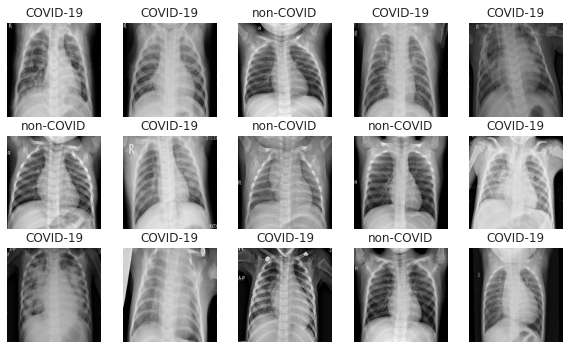

In [20]:
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [21]:
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break
    return numpy_images, numpy_labels

x_test, y_test = dataset_to_numpy_util(test_ds, Test_IMG_COUNT)

print("Evaluation Dataset:")
print('X shape: ', x_test.shape,' Y shape: ', y_test.shape)

Evaluation Dataset:
X shape:  (619, 224, 224, 3)  Y shape:  (619, 2)


In [ ]:
'''def weight_classes(extra_weight=False, ew_value=1):
    total_COUNT = COUNT_COVID + COUNT_Non_COVID

    weight_for_0 = (1 / COUNT_Non_COVID) * total_COUNT / 2.0 
    weight_for_1 = (1 / COUNT_COVID) * total_COUNT / 2.0
    
    if extra_weight:
        weight_for_1 *= ew_value

    class_weight = {0: weight_for_0, 1: weight_for_1}

    print(f'Weight for class 0: {weight_for_0}')
    print(f'Weight for class 1: {weight_for_1}')
    
    return class_weight'''

In [ ]:
#class_weight = weight_classes(extra_weight=False, ew_value=1.5)

Weight for class 0: 1.1879323597232898
Weight for class 1: 0.8634078212290502


In [22]:
from tensorflow.keras.applications.resnet50 import ResNet50


In [23]:
def build_model(OPTIMIZER, LOSS, METRICS):
    model = None
    inputs = layers.Input(shape=input_shape)
    x = img_augmentation(inputs)
    x = preprocessing.Rescaling(1.0 / 255)(x)
    baseModel = ResNet50(include_top=False, input_tensor=x, weights="imagenet", pooling ='avg')

    baseModel.trainable = False

    x = BatchNormalization(axis = -1, name="Batch-Normalization-1")(baseModel.output)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization(axis = -1, name="Batch-Normalization-2")(x)
    x = Dropout(.2, name="Dropout-1")(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization(axis = -1, name="Batch-Normalization-3")(x)
    
    outputs = Dense(NUM_CLASSES, activation="softmax", name="Classifier")(x)
    model = tf.keras.Model(inputs=baseModel.input, outputs=outputs, name="Deep-COVID")
    
    model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)
        
    return model

In [24]:
model = build_model(OPTIMIZER, LOSS, METRICS)

In [25]:
def fit_model(Epochs, Callbacks, class_weight=None):
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=Epochs,
        callbacks=Callbacks,
        verbose=2
    )
    return history
    
history = fit_model(Epochs, Callbacks)

Epoch 1/50
16/16 - 35s - loss: 0.8625 - accuracy: 0.8553 - val_loss: 0.9684 - val_accuracy: 0.4121 - lr: 0.0010 - 35s/epoch - 2s/step
Epoch 2/50
16/16 - 31s - loss: 0.6769 - accuracy: 0.9186 - val_loss: 0.9047 - val_accuracy: 0.5879 - lr: 9.9901e-04 - 31s/epoch - 2s/step
Epoch 3/50
16/16 - 23s - loss: 0.6139 - accuracy: 0.9358 - val_loss: 0.8659 - val_accuracy: 0.5879 - lr: 9.9606e-04 - 23s/epoch - 1s/step
Epoch 4/50
16/16 - 23s - loss: 0.5816 - accuracy: 0.9474 - val_loss: 0.8499 - val_accuracy: 0.5879 - lr: 9.9115e-04 - 23s/epoch - 1s/step
Epoch 5/50
16/16 - 23s - loss: 0.5531 - accuracy: 0.9540 - val_loss: 0.8745 - val_accuracy: 0.5879 - lr: 9.8431e-04 - 23s/epoch - 1s/step
Epoch 6/50
16/16 - 23s - loss: 0.5379 - accuracy: 0.9570 - val_loss: 0.8254 - val_accuracy: 0.5879 - lr: 9.7555e-04 - 23s/epoch - 1s/step
Epoch 7/50
16/16 - 22s - loss: 0.5159 - accuracy: 0.9641 - val_loss: 0.9286 - val_accuracy: 0.5879 - lr: 9.6492e-04 - 22s/epoch - 1s/step
Epoch 8/50
16/16 - 23s - loss: 0.5017 

In [26]:
def evaluate_model(model):
    results = model.evaluate(test_ds, return_dict=True)
    print ('\nModel Evaluation:')
    print(results['accuracy']*100)
    return results
    
results = evaluate_model(model)

5/5 [==============================] - 6s 275ms/step - loss: 0.9052 - accuracy: 0.5703

Model Evaluation:
57.027459144592285


In [27]:
def fine_tune(OPTIMIZER, LOSS, METRICS):
    for layer in model.layers[-54:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
            
    model.compile(optimizer = Fine_Tune_OPTIMIZER, loss = LOSS, metrics = METRICS)
    return model

In [28]:
model.summary()

Model: "Deep-COVID"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Augmentation (Sequential)      (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['Augmentation[0][0]']           
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['rescaling[0][0]']     

In [29]:
model = fine_tune(Fine_Tune_OPTIMIZER, LOSS, METRICS)

In [30]:
history = fit_model(Fine_Tune_Epochs, FT_Callbacks)

Epoch 1/60

Epoch 1: val_accuracy improved from -inf to 0.41212, saving model to /content/drive/MyDrive/Best-Model-FT_resnet.h5
16/16 - 37s - loss: 1.0352 - accuracy: 0.5862 - val_loss: 522468.7188 - val_accuracy: 0.4121 - lr: 0.0010 - 37s/epoch - 2s/step
Epoch 2/60

Epoch 2: val_accuracy did not improve from 0.41212
16/16 - 26s - loss: 0.9021 - accuracy: 0.6105 - val_loss: 5996986.5000 - val_accuracy: 0.4121 - lr: 0.0010 - 26s/epoch - 2s/step
Epoch 3/60

Epoch 3: val_accuracy did not improve from 0.41212
16/16 - 26s - loss: 0.8165 - accuracy: 0.7061 - val_loss: 429272.7812 - val_accuracy: 0.4121 - lr: 0.0010 - 26s/epoch - 2s/step
Epoch 4/60

Epoch 4: val_accuracy improved from 0.41212 to 0.58788, saving model to /content/drive/MyDrive/Best-Model-FT_resnet.h5
16/16 - 26s - loss: 0.7864 - accuracy: 0.7329 - val_loss: 3436092.7500 - val_accuracy: 0.5879 - lr: 0.0010 - 26s/epoch - 2s/step
Epoch 5/60

Epoch 5: val_accuracy did not improve from 0.58788
16/16 - 24s - loss: 0.7587 - accuracy:

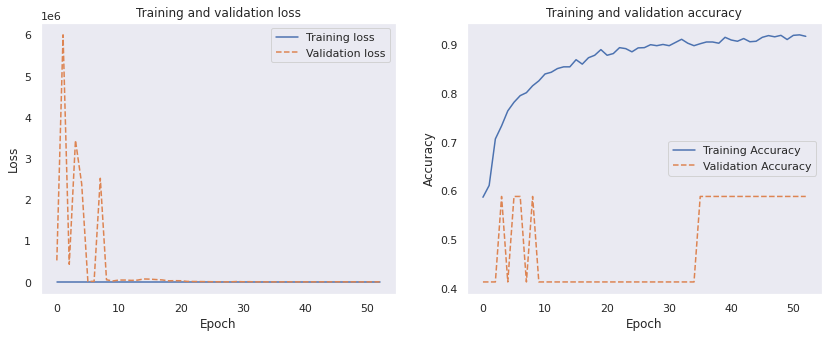

In [31]:
def Plot_Learning_Curves():
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    sns.set(style="dark")
    plt.rcParams['figure.figsize'] = (14, 5)

    plt.subplot(1,2,1)
    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, linestyle="--", label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss') 
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, linestyle="--", label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy') 
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()
    
Plot_Learning_Curves()

In [32]:
def evaluate_model(model):
    results = model.evaluate(test_ds, return_dict=True)
    print ('\nModel Evaluation:')
    print(results['accuracy']*100)
    return results
    
results = evaluate_model(model)

5/5 [==============================] - 6s 169ms/step - loss: 762.1636 - accuracy: 0.4297

Model Evaluation:
42.97253489494324


Shape of preds:  (619, 2)


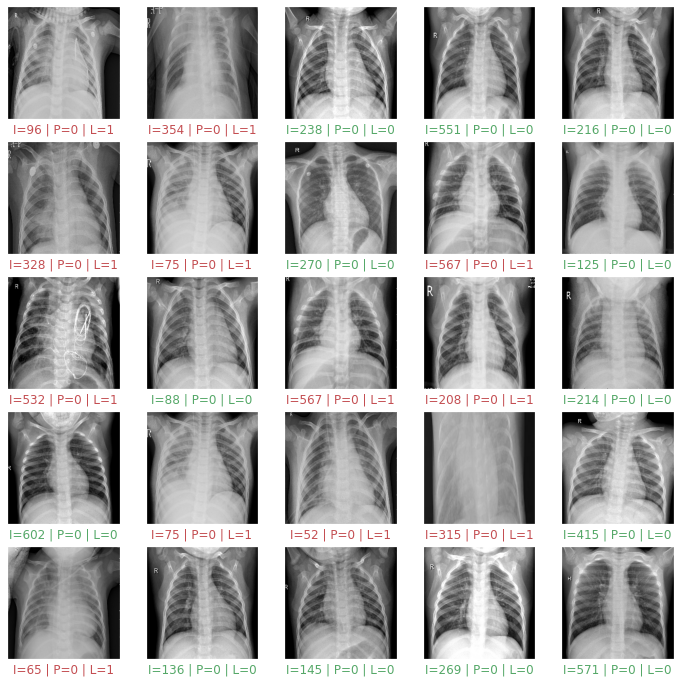

In [33]:
preds = model.predict(x_test)
print('Shape of preds: ', preds.shape)
plt.figure(figsize = (12, 12))

R = np.random.choice(preds.shape[0])

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    R = np.random.choice(preds.shape[0])
    pred = np.argmax(preds[R])
    actual = np.argmax(y_test[R])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('I={} | P={} | L={}'.format(R, pred, actual), color = col)
    plt.imshow(((x_test[R]* 255).astype(np.uint8)), cmap='binary')
plt.show()

In [34]:
categories = ['COVID-19', 'Non-COVID-19']
preds = np.round(preds,0)
class_metrics = metrics.classification_report(y_test, preds, target_names = categories, zero_division = 0)
print (class_metrics)

              precision    recall  f1-score   support

    COVID-19       0.43      1.00      0.60       266
Non-COVID-19       0.00      0.00      0.00       353

   micro avg       0.43      0.43      0.43       619
   macro avg       0.21      0.50      0.30       619
weighted avg       0.18      0.43      0.26       619
 samples avg       0.43      0.43      0.43       619



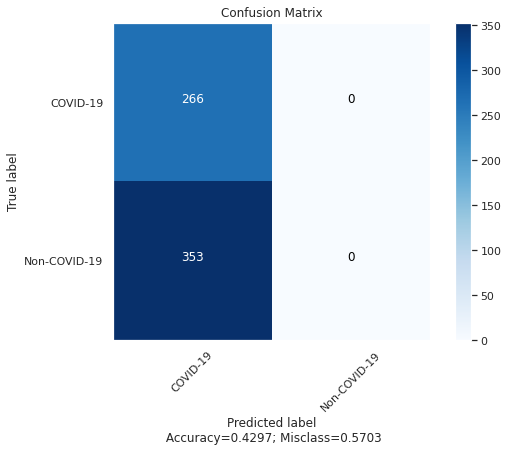

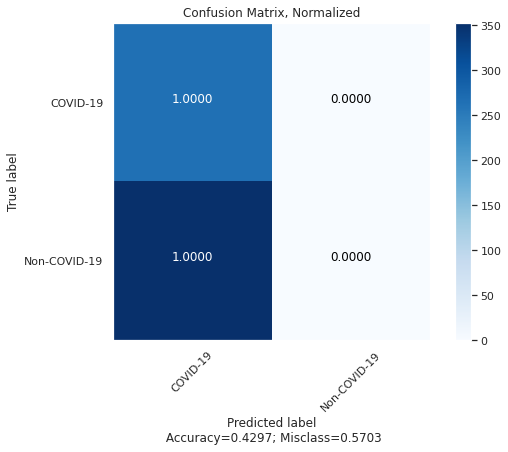

In [35]:
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), preds.argmax(axis=1))

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\n Accuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = False,
                      target_names = categories,
                      title        = "Confusion Matrix")

plot_confusion_matrix(cm           = np.array(matrix), 
                      normalize    = True,
                      target_names = categories,
                      title        = "Confusion Matrix, Normalized")

In [36]:
test_image = x_test[0]
x = np.expand_dims(test_image, axis=0)
x = x/255

images = np.vstack([x])

classes = model.predict(images, batch_size=BATCH_SIZE)
classes = np.argmax(classes,axis=1)

print ('Class:', categories[int(classes)] )

Class: COVID-19
